Код для робота (менять не надо): 

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)


Добавьте вычисление параметра steer через PID controller в этой клетке:

In [2]:
class PIDController:
    def __init__(self, tau_p, tau_d, tau_i):
        self.tau_p = tau_p
        self.tau_d = tau_d
        self.tau_i = tau_i
        self.error = None
        self.integral = 0
    
    def run(self, y, orientation, target_y, dt=0.1):
        error = target_y - y
        
        if self.error is None:
            d_error = 0
        else:
            d_error = (error - self.error) / dt
        
        self.integral += error * dt
        self.error = error
        
        return self.tau_p * error + self.tau_i * self.integral + self.tau_d * d_error

In [3]:
def run(robot, tau_p, tau_d, tau_i, n=200, speed=1.0):
    controller = PIDController(tau_p, tau_d, tau_i)
    
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = controller.run(robot.y, robot.orientation, target_y=0.0)
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

Запус и отрисовка траектории, тут нужно подобрать оптимальные параметры PID (сейчас стоят 1, 1, 1).

In [4]:
def plot(tau_p, tau_d, tau_i):
    robot = Robot()
    robot.set(0, 1, 0)

    x_trajectory, y_trajectory = run(robot, tau_p, tau_d, tau_i)

    plt.plot(x_trajectory, np.zeros(len(x_trajectory)), 'r', label='reference')
    plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
    plt.legend()
    plt.show()

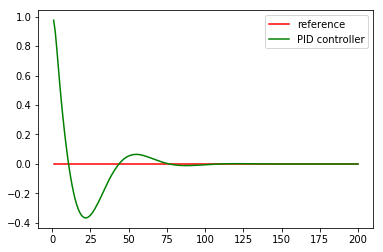

In [5]:
plot(1, 1, 1)

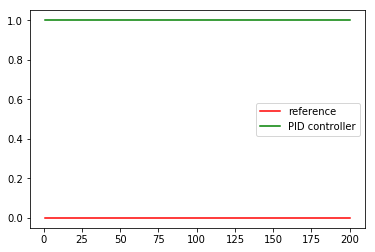

In [6]:
plot(0, 1, 0)

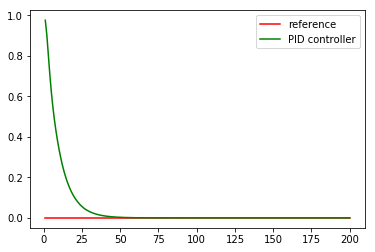

In [7]:
plot(1, 1, 0)

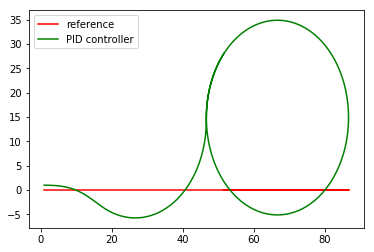

In [8]:
plot(0, 0, 1)